## @author - Pardeep
## transfer learning model using MobileNetV2
### reference :- https://keras.io/api/applications/mobilenet/#mobilenetv2-function

# Data Preprocessing

In [1]:
# using dplifolders splitting the data into train and test
import splitfolders

In [2]:
input_dataset="Segmented Medicinal Leaf Images"
output_dataset="splitted data"
splitfolders.ratio(input_dataset,output_dataset,seed=42,ratio=(.7,.2,.1)) # will split in train(70%), test(20%) and validation(10%)

Copying files: 1835 files [00:01, 1288.92 files/s]


In [3]:
from keras.preprocessing.image import ImageDataGenerator

### Preprocessing the Training set

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('splitted data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1273 images belonging to 30 classes.


### Preprocessing the Test set

In [5]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('splitted data/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 206 images belonging to 30 classes.


### Preprocessing the val set

In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)
val_set = test_datagen.flow_from_directory('splitted data/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 356 images belonging to 30 classes.


# importing transfer learning model

In [7]:
# import necessary library
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential
from keras.layers import *

In [8]:
# load and creare a model object
v2model = MobileNetV2(input_shape=[224,224,3], weights='imagenet', include_top=False)
# model summary
v2model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# preprocessing pre trained model

In [9]:
for layer in v2model.layers:
    layer.trainable = False

## adding layer for flattening the outputs from previous layers

In [10]:
x = Flatten()(v2model.output)

## adding layer for classification

In [11]:
from glob import glob

In [12]:
# getting number of output classes
folders = glob('./splitted data/train/*')

In [13]:
prediction = Dense(len(folders), activation='softmax')(x)

In [14]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

In [15]:
# create a model object
model = Model(inputs=v2model.input, outputs=prediction)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Training the transfer learning model

### Compiling the CNN

In [17]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### To avoid model to overfitting 

In [18]:
from keras.callbacks import EarlyStopping

In [19]:
earlystop = EarlyStopping(monitor='val_accuracy', patience=5,verbose=2)

### Training the CNN on the Training set and evaluating it on the Test set

In [20]:
a= model.fit(training_set, validation_data = val_set,callbacks= earlystop,epochs = 20)

Epoch 1/20
40/40 [==============================] - 62s 1s/step - loss: 1.2887 - accuracy: 0.2611 - val_loss: 0.0995 - val_accuracy: 0.8933
Epoch 2/20
40/40 [==============================] - 52s 1s/step - loss: 0.0560 - accuracy: 0.9337 - val_loss: 0.0325 - val_accuracy: 0.9522
Epoch 3/20
40/40 [==============================] - 52s 1s/step - loss: 0.0218 - accuracy: 0.9679 - val_loss: 0.0250 - val_accuracy: 0.9691
Epoch 4/20
40/40 [==============================] - 51s 1s/step - loss: 0.0119 - accuracy: 0.9843 - val_loss: 0.0323 - val_accuracy: 0.9522
Epoch 5/20
40/40 [==============================] - 51s 1s/step - loss: 0.0103 - accuracy: 0.9882 - val_loss: 0.0204 - val_accuracy: 0.9691
Epoch 6/20
40/40 [==============================] - 52s 1s/step - loss: 0.0114 - accuracy: 0.9921 - val_loss: 0.0241 - val_accuracy: 0.9579
Epoch 7/20
40/40 [==============================] - 52s 1s/step - loss: 0.0077 - accuracy: 0.9926 - val_loss: 0.0333 - val_accuracy: 0.9663
Epoch 8/20
40/40 [==

## Making a single prediction

In [21]:
from tensorflow import keras
import tensorflow as tf

In [27]:
img = keras.preprocessing.image.load_img(
    "Segmented Medicinal Leaf Images/Citrus Limon (Lemon)/CL-S-013.jpg", target_size=(224,224,3)
)
img_array = keras.preprocessing.image.img_to_array(img)/255
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
result = predictions[0]

In [28]:
if result[0] == result.max():
  prediction = 'Alpinia Galanga (Rasna)'
elif result[1] == result.max():
    prediction = 'Amaranthus Viridis (Arive-Dantu)'
elif result[2] == result.max():
    prediction = 'Artocarpus Heterophyllus (Jackfruit)'
elif result[3] == result.max():
    prediction = 'Azadirachta Indica (Neem)'
elif result[4] == result.max():
    prediction = 'Basella Alba (Basale)'
elif result[5] == result.max():
    prediction = 'Brassica Juncea (Indian Mustard)'
elif result[6] == result.max():
    prediction = 'Carissa Carandas (Karanda)'
elif result[7] == result.max():
    prediction = 'Citrus Limon (Lemon)'
elif result[8] == result.max():
    prediction = 'Ficus Auriculata (Roxburgh fig)'
elif result[9] == result.max():
    prediction = 'Ficus Religiosa (Peepal Tree)'
elif result[10] == result.max():
    prediction = 'Hibiscus Rosa-sinensis'
elif result[11] == result.max():
    prediction = 'Jasminum (Jasmine)'
elif result[12] == result.max():
    prediction = 'Mangifera Indica (Mango)'
elif result[12] == result.max():
    prediction = 'Mentha (Mint)'
elif result[14] == result.max():
    prediction = 'Moringa Oleifera (Drumstick)'
elif result[15] == result.max():
    prediction = 'Muntingia Calabura (Jamaica Cherry-Gasagase)'
elif result[16] == result.max():
    prediction = 'Murraya Koenigii (Curry)'
elif result[17] == result.max():
    prediction = 'Nerium Oleander (Oleander)'
elif result[18] == result.max():
    prediction = 'Nyctanthes Arbor-tristis (Parijata)'
elif result[19] == result.max():
    prediction = 'Ocimum Tenuiflorum (Tulsi)'
elif result[20] == result.max():
    prediction = 'Piper Betle (Betel)'
elif result[21] == result.max():
    prediction = 'Plectranthus Amboinicus (Mexican Mint)'
elif result[22] == result.max():
    prediction = 'Pongamia Pinnata (Indian Beech)'
elif result[23] == result.max():
    prediction = 'Psidium Guajava (Guava)'
elif result[24] == result.max():
    prediction = 'Punica Granatum (Pomegranate)'
elif result[25] == result.max():
    prediction = 'Santalum Album (Sandalwood)'
elif result[26] == result.max():
    prediction = 'Syzygium Cumini (Jamun)'
elif result[27] == result.max():
    prediction = 'Syzygium Jambos (Rose Apple)'
elif result[28] == result.max():
    prediction = 'Tabernaemontana Divaricata (Crape Jasmine)'
else:
    prediction = 'Trigonella Foenum-graecum (Fenugreek)'

In [29]:
print(prediction)

Citrus Limon (Lemon)


### accuracy and losses

In [23]:
test_loss, test_acc =model.evaluate(test_set,verbose = 2)
print("Test accuracy: ",test_acc)

7/7 - 6s - loss: 0.0240 - accuracy: 0.9709
Test accuracy:  0.9708737730979919


In [31]:
print("Test loss: ",test_loss)

Test loss:  0.024033067747950554


In [24]:
import matplotlib.pyplot as plt

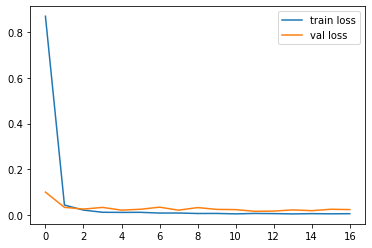

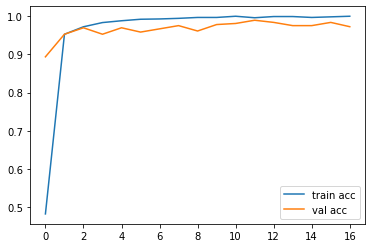

In [25]:
# plot the loss
plt.plot(a.history['loss'], label='train loss')
plt.plot(a.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(a.history['accuracy'], label='train acc')
plt.plot(a.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

## saving a model

In [30]:
import tensorflow as tf

from keras.models import load_model

model.save('mobilenetv2.h5')